In [296]:

# data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk

# import language_tool_python #conda install conda-forge::language_tool_python
# language_tool = language_tool_python.LanguageTool('en-US')

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import TruncatedSVD
# Pipeline and model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import BernoulliNB
# Score of models
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report, confusion_matrix

In [297]:
url = "SMSSpamCollection.txt"
df = pd.read_csv(url, sep='\t', header=None )
df.rename(columns={0:'type',1:'mail'}, inplace=True)
df


,type,mail
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [298]:
df['minuscule']=df['mail'].str.lower()
df

,type,mail,minuscule
0,ham,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ..."
1,ham,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor... u c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah i don't think he goes to usf, he lives aro..."
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?,will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s...","pity, * was in mood for that. so...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...,the guy did some bitching but i acted like i'd...


In [299]:
# tokenizer avec RE (regular expressions)
from nltk.tokenize import RegexpTokenizer
nltk.download('punkt')

# tokenizer = RegexpTokenizer(r"[a-zA-Z]\w+\'?\w*")
tokenizer = RegexpTokenizer(r"\b\w+\b|\d{2} \d{2} \d{2} \d{2} \d{2}")
df['token'] = df['minuscule'].apply(lambda x: tokenizer.tokenize(x))
df


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MOHAM\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,type,mail,minuscule,token
0,ham,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ...","[go, until, jurong, point, crazy, available, o..."
1,ham,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f..."
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor... u c already then say...,"[u, dun, say, so, early, hor, u, c, already, t..."
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah i don't think he goes to usf, he lives aro...","[nah, i, don, t, think, he, goes, to, usf, he,..."
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,..."
5568,ham,Will ü b going to esplanade fr home?,will ü b going to esplanade fr home?,"[will, ü, b, going, to, esplanade, fr, home]"
5569,ham,"Pity, * was in mood for that. So...any other s...","pity, * was in mood for that. so...any other s...","[pity, was, in, mood, for, that, so, any, othe..."
5570,ham,The guy did some bitching but I acted like i'd...,the guy did some bitching but i acted like i'd...,"[the, guy, did, some, bitching, but, i, acted,..."


In [300]:

from nltk.corpus import stopwords
nltk.download('stopwords')
# Supprimer les stop words
stop = stopwords.words('english')
df['without_stopwords']=df['token'].apply(lambda x: [word for word in x if word not in stop])
df


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MOHAM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,type,mail,minuscule,token,without_stopwords
0,ham,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ...","[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor... u c already then say...,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah i don't think he goes to usf, he lives aro...","[nah, i, don, t, think, he, goes, to, usf, he,...","[nah, think, goes, usf, lives, around, though]"
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,...","[2nd, time, tried, 2, contact, u, u, 750, poun..."
5568,ham,Will ü b going to esplanade fr home?,will ü b going to esplanade fr home?,"[will, ü, b, going, to, esplanade, fr, home]","[ü, b, going, esplanade, fr, home]"
5569,ham,"Pity, * was in mood for that. So...any other s...","pity, * was in mood for that. so...any other s...","[pity, was, in, mood, for, that, so, any, othe...","[pity, mood, suggestions]"
5570,ham,The guy did some bitching but I acted like i'd...,the guy did some bitching but i acted like i'd...,"[the, guy, did, some, bitching, but, i, acted,...","[guy, bitching, acted, like, interested, buyin..."


In [301]:

from nltk.stem import PorterStemmer

# stemmer notre list

stemmer = PorterStemmer()
df['PorterStemmer'] = df['without_stopwords'].apply(lambda x: [stemmer.stem(word) for word in x])
df

,type,mail,minuscule,token,without_stopwords,PorterStemmer
0,ham,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ...","[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazi, avail, bugi, n, gre..."
1,ham,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin...","[free, entri, 2, wkli, comp, win, fa, cup, fin..."
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor... u c already then say...,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, earli, hor, u, c, alreadi, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah i don't think he goes to usf, he lives aro...","[nah, i, don, t, think, he, goes, to, usf, he,...","[nah, think, goes, usf, lives, around, though]","[nah, think, goe, usf, live, around, though]"
...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,...","[2nd, time, tried, 2, contact, u, u, 750, poun...","[2nd, time, tri, 2, contact, u, u, 750, pound,..."
5568,ham,Will ü b going to esplanade fr home?,will ü b going to esplanade fr home?,"[will, ü, b, going, to, esplanade, fr, home]","[ü, b, going, esplanade, fr, home]","[ü, b, go, esplanad, fr, home]"
5569,ham,"Pity, * was in mood for that. So...any other s...","pity, * was in mood for that. so...any other s...","[pity, was, in, mood, for, that, so, any, othe...","[pity, mood, suggestions]","[piti, mood, suggest]"
5570,ham,The guy did some bitching but I acted like i'd...,the guy did some bitching but i acted like i'd...,"[the, guy, did, some, bitching, but, i, acted,...","[guy, bitching, acted, like, interested, buyin...","[guy, bitch, act, like, interest, buy, someth,..."


In [302]:

df['clean'] = df['without_stopwords'].apply(lambda x: " ".join(x))
df

,type,mail,minuscule,token,without_stopwords,PorterStemmer,clean
0,ham,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ...","[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazi, avail, bugi, n, gre...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]",ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin...","[free, entri, 2, wkli, comp, win, fa, cup, fin...",free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor... u c already then say...,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, earli, hor, u, c, alreadi, say]",u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah i don't think he goes to usf, he lives aro...","[nah, i, don, t, think, he, goes, to, usf, he,...","[nah, think, goes, usf, lives, around, though]","[nah, think, goe, usf, live, around, though]",nah think goes usf lives around though
...,...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried 2 contact u...,"[this, is, the, 2nd, time, we, have, tried, 2,...","[2nd, time, tried, 2, contact, u, u, 750, poun...","[2nd, time, tri, 2, contact, u, u, 750, pound,...",2nd time tried 2 contact u u 750 pound prize 2...
5568,ham,Will ü b going to esplanade fr home?,will ü b going to esplanade fr home?,"[will, ü, b, going, to, esplanade, fr, home]","[ü, b, going, esplanade, fr, home]","[ü, b, go, esplanad, fr, home]",ü b going esplanade fr home
5569,ham,"Pity, * was in mood for that. So...any other s...","pity, * was in mood for that. so...any other s...","[pity, was, in, mood, for, that, so, any, othe...","[pity, mood, suggestions]","[piti, mood, suggest]",pity mood suggestions
5570,ham,The guy did some bitching but I acted like i'd...,the guy did some bitching but i acted like i'd...,"[the, guy, did, some, bitching, but, i, acted,...","[guy, bitching, acted, like, interested, buyin...","[guy, bitch, act, like, interest, buy, someth,...",guy bitching acted like interested buying some...


In [303]:
df['len']=df['clean'].str.len()
# df['nombre_mots']=df['mail'].str.split().str.len()
df['nombre_mots']=df['token'].str.len()


pattern = r"http\S+"
df['http_compt']=df['mail'].apply(lambda x: len(re.findall(pattern, x)))

pattern = r"([+-]?(?=\.\d|\d)(?:\d+)?(?:\.?\d*))(?:[Ee]([+-]?\d+))?"
df['phone_compt']=df['mail'].apply(lambda x: len(re.findall(pattern, x)))

pattern = r"[-A-Za-z0-9!#$%&'*+/=?^_`{|}~]+(?:\.[-A-Za-z0-9!#$%&'*+/=?^_`{|}~]+)*@(?:[A-Za-z0-9](?:[-A-Za-z0-9]*[A-Za-z0-9])?\.)+[A-Za-z0-9](?:[-A-Za-z0-9]*[A-Za-z0-9])?"
df['mail_compt']=df['mail'].apply(lambda x: len(re.findall(pattern, x)))

df[df['http_compt']>0]


,type,mail,minuscule,token,without_stopwords,PorterStemmer,clean,len,nombre_mots,http_compt,phone_compt,mail_compt
15,spam,"XXXMobileMovieClub: To use your credit, click ...","xxxmobilemovieclub: to use your credit, click ...","[xxxmobilemovieclub, to, use, your, credit, cl...","[xxxmobilemovieclub, use, credit, click, wap, ...","[xxxmobilemovieclub, use, credit, click, wap, ...",xxxmobilemovieclub use credit click wap link n...,115,23,1,0,0
305,spam,SMS. ac Blind Date 4U!: Rodds1 is 21/m from Ab...,sms. ac blind date 4u!: rodds1 is 21/m from ab...,"[sms, ac, blind, date, 4u, rodds1, is, 21, m, ...","[sms, ac, blind, date, 4u, rodds1, 21, aberdee...","[sm, ac, blind, date, 4u, rodds1, 21, aberdeen...",sms ac blind date 4u rodds1 21 aberdeen united...,115,28,1,7,0
518,spam,Your credits have been topped up for http://ww...,your credits have been topped up for http://ww...,"[your, credits, have, been, topped, up, for, h...","[credits, topped, http, www, bubbletext, com, ...","[credit, top, http, www, bubbletext, com, rene...",credits topped http www bubbletext com renewal...,57,16,1,0,0
635,spam,"Dear Voucher Holder, 2 claim this weeks offer,...","dear voucher holder, 2 claim this weeks offer,...","[dear, voucher, holder, 2, claim, this, weeks,...","[dear, voucher, holder, 2, claim, weeks, offer...","[dear, voucher, holder, 2, claim, week, offer,...",dear voucher holder 2 claim weeks offer pc go ...,119,30,1,3,0
833,spam,"Dear Voucher Holder, To claim this weeks offer...","dear voucher holder, to claim this weeks offer...","[dear, voucher, holder, to, claim, this, weeks...","[dear, voucher, holder, claim, weeks, offer, p...","[dear, voucher, holder, claim, week, offer, pc...",dear voucher holder claim weeks offer pc pleas...,122,31,1,1,0
881,spam,Reminder: You have not downloaded the content ...,reminder: you have not downloaded the content ...,"[reminder, you, have, not, downloaded, the, co...","[reminder, downloaded, content, already, paid,...","[remind, download, content, alreadi, paid, got...",reminder downloaded content already paid goto ...,81,21,1,0,0
1105,spam,Message Important information for O2 user. Tod...,message important information for o2 user. tod...,"[message, important, information, for, o2, use...","[message, important, information, o2, user, to...","[messag, import, inform, o2, user, today, luck...",message important information o2 user today lu...,120,28,1,2,0
3059,spam,You are now unsubscribed all services. Get ton...,you are now unsubscribed all services. get ton...,"[you, are, now, unsubscribed, all, services, g...","[unsubscribed, services, get, tons, sexy, babe...","[unsubscrib, servic, get, ton, sexi, babe, hun...",unsubscribed services get tons sexy babes hunk...,99,25,1,0,0
3174,spam,"Dear Voucher Holder, To claim this weeks offer...","dear voucher holder, to claim this weeks offer...","[dear, voucher, holder, to, claim, this, weeks...","[dear, voucher, holder, claim, weeks, offer, p...","[dear, voucher, holder, claim, week, offer, pc...",dear voucher holder claim weeks offer pc pleas...,90,24,1,0,0
3463,spam,Bloomberg -Message center +447797706009 Why wa...,bloomberg -message center +447797706009 why wa...,"[bloomberg, message, center, 447797706009, why...","[bloomberg, message, center, 447797706009, wai...","[bloomberg, messag, center, 447797706009, wait...",bloomberg message center 447797706009 wait app...,82,14,1,1,0


In [304]:



# def count_errors(text):
#     m = language_tool.check(text)
#     return len(m)


# df['errors'] = df['mail'].apply(count_errors)
# df[['type', 'errors']].boxplot(column='errors', by='type')


<Axes: title={'center': 'len'}, xlabel='type'>

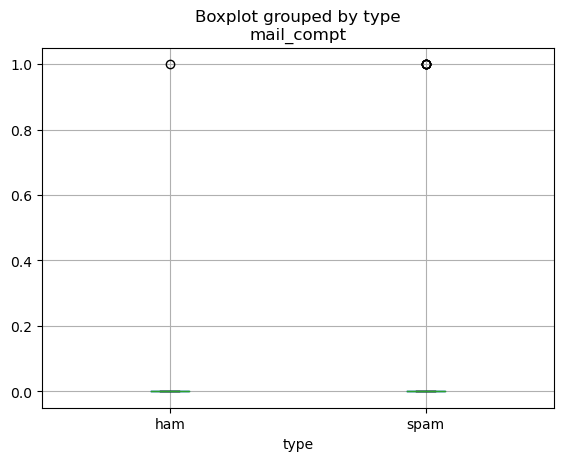

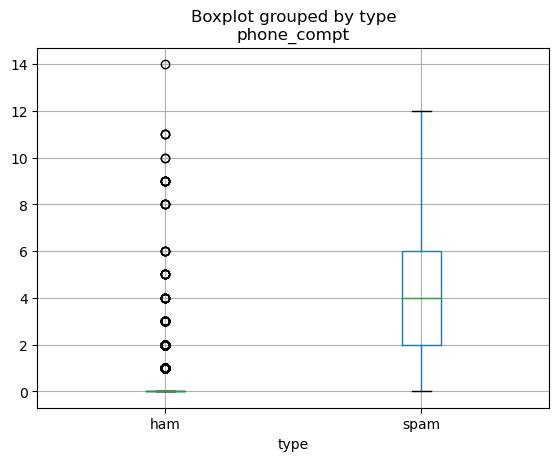

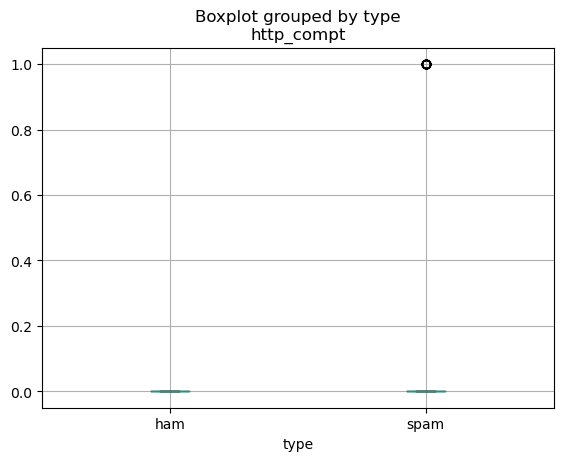

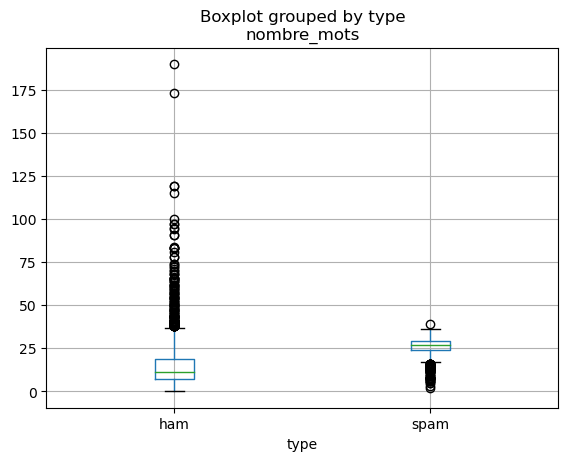

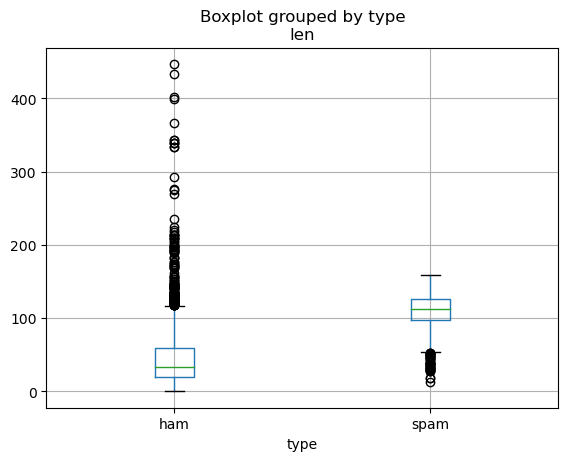

In [305]:

df[['type', 'mail_compt']].boxplot(column='mail_compt', by='type')
df[['type', 'phone_compt']].boxplot(column='phone_compt', by='type')
df[['type', 'http_compt']].boxplot(column='http_compt', by='type')
df[['type', 'nombre_mots']].boxplot(column='nombre_mots', by='type')
df[['type', 'len']].boxplot(column='len', by='type')

In [306]:
# Il est important de noter que ces techniques peuvent introduire leur propre biais et doivent donc être utilisées avec prudence.
# Par exemple, le suréchantillonnage peut conduire à un surapprentissage sur la classe minoritaire,
# tandis que le sous-échantillonnage peut entraîner une perte d’informations importantes



In [307]:
X = df.drop(['type'], axis=1)
y = df['type']
X.shape


(5572, 11)

In [308]:
y.shape

(5572,)

In [309]:
from imblearn.under_sampling import RandomUnderSampler #conda install conda-forge::imbalanced-learn

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, stratify=y_res, test_size=0.2, random_state=42)


In [310]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)


In [311]:
# C'est juste un test
# vectorizertest = TfidfVectorizer(decode_error='ignore', analyzer='char_wb', ngram_range=(2, 2), min_df=10)
# matrix = vectorizertest.fit_transform(df['clean'])
# matrix.shape


In [312]:
# matrix.toarray()

In [313]:

# vectorizertest.get_feature_names_out() # C'est le dictionnaire

In [314]:
column_text = X_train.select_dtypes(include=['object']).columns[0]
column_text

'mail'

In [315]:
column_num = X_train.select_dtypes(exclude=['object']).columns
column_num
# Transformation of textual variables
transfo_text_TFid = Pipeline(steps=[
    ('Tfid', TfidfVectorizer(lowercase=False, decode_error='ignore', analyzer='char_wb', ngram_range=(2, 2), min_df=3))
    
])

transfo_text_CountVect = Pipeline(steps=[  
    ('boCountVectorizerw', CountVectorizer(stop_words=stop,decode_error='ignore', analyzer='char_wb',strip_accents='unicode', ngram_range=(2, 2)))
])


# Class ColumnTransformer : apply alls steps on the whole dataset
preparation = ColumnTransformer(
    transformers=[
        ('TFid&data', transfo_text_TFid , 'mail'), #TFIDF ne prend pas de listes comme arguments
        # ('CountVect&data', transfo_text_CountVect , 'clean'),
        ('MinMaxScaler&data',MinMaxScaler(), ['len', 'nombre_mots']) #['http_compt', 'mail_compt']
        # ('data',StandardScaler(), column_num) #Les classifieurs NB ne prend pas de valeur négatif
        # ('data',RobustScaler(), column_num) #Les classifieurs NB ne prend pas de valeur négatif
    ])
preparation


ColumnTransformer(transformers=[('TFid&data',
                                 Pipeline(steps=[('Tfid',
                                                  TfidfVectorizer(analyzer='char_wb',
                                                                  decode_error='ignore',
                                                                  lowercase=False,
                                                                  min_df=3,
                                                                  ngram_range=(2,
                                                                               2)))]),
                                 'mail'),
                                ('MinMaxScaler&data', MinMaxScaler(),
                                 ['len', 'nombre_mots'])])

In [316]:
# Creation of model : a ready to use pipeline for ML process


classifier =ComplementNB()                                        #0.9838516746411483
# classifier = MultinomialNB()                                      #0.9856459330143541
# classifier = BernoulliNB(force_alpha=True)

# classifier =SVC(gamma='auto')                                     #0.9742822966507177
# classifier =SVC(gamma=2, C=1, random_state=42)                    #0.8941387559808612

# classifier =KNeighborsClassifier(7)                               #0.9527511961722488

# classifier =LogisticRegression(solver='liblinear', C=1e3)           #0.9904306220095693



# classifier =RidgeClassifier(tol=1e-2, solver="sparse_cg")         #0.9811659192825112
# classifier =RandomForestClassifier(max_depth=200, random_state=42)#0.9838516746411483
# classifier =DecisionTreeClassifier()                              #0.9700956937799043


In [317]:
# Dimensionality reduction using truncated SVD 
svd = TruncatedSVD(n_components=777, n_iter=7, random_state=42)
# PCA

In [318]:
model_lm = Pipeline([
    ('vectorizer', preparation),
    # ('svd', svd), #Ça génère des valeurs négatives et les NB n'aime pas ça
    ('classifier', classifier)
])

In [319]:

# Fit the model
model_lm.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 ColumnTransformer(transformers=[('TFid&data',
                                                  Pipeline(steps=[('Tfid',
                                                                   TfidfVectorizer(analyzer='char_wb',
                                                                                   decode_error='ignore',
                                                                                   lowercase=False,
                                                                                   min_df=3,
                                                                                   ngram_range=(2,
                                                                                                2)))]),
                                                  'mail'),
                                                 ('MinMaxScaler&data',
                                                  MinMaxScaler(),
                                                  ['len', 'nombre_mots'])])),
                ('classifier', ComplementNB())])

In [321]:
# Predict on test data

y_pred = model_lm.predict(X_test)

In [322]:
# Performance of the model
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9431438127090301


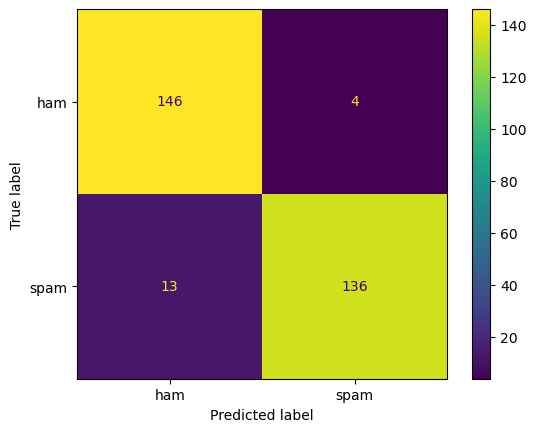

In [323]:


ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [324]:

# Afficher le rapport de classification
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ham       0.92      0.97      0.94       150
        spam       0.97      0.91      0.94       149

    accuracy                           0.94       299
   macro avg       0.94      0.94      0.94       299
weighted avg       0.94      0.94      0.94       299



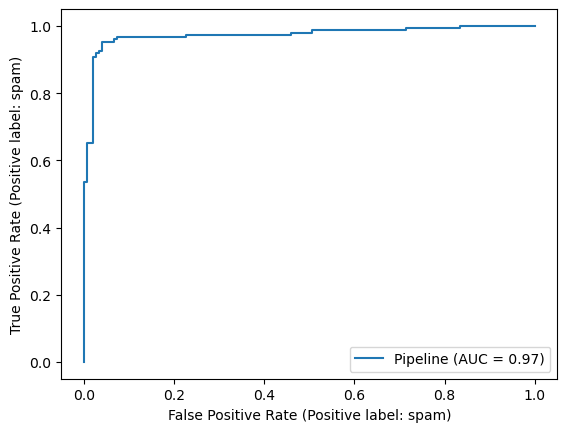

In [325]:

svc_disp = RocCurveDisplay.from_estimator(model_lm, X_test, y_test)

In [326]:

# plt.hist(model_lm.decision_function(X_test), bins=50)
# plt.show()